In [1]:
import networkx as nx
import random
import community as community_louvain
import pandas as pd
from collections import Counter


import matplotlib.pyplot as plt

In [33]:

def calculate_edge_counts(G_sub, A_nodes, B_nodes):
    """
    Calculate edge counts from B_nodes to A_nodes for the subgraph G_sub.

    Parameters:
    - G_sub: NetworkX graph (subgraph)
    - A_nodes: List of nodes in group A
    - B_nodes: List of nodes in group B

    Returns:
    - edges_from_B_to_A_df: DataFrame with edge counts from B_nodes to A_nodes
    - binary_edge_count_df: Binary DataFrame indicating if edge count > 0
    - edge_count_refined_df: DataFrame with counts of edge contributions from each node in B_nodes
    """
    # Filter A_nodes and B_nodes to only include valid nodes
    valid_A_nodes = [a for a in A_nodes if a in G_sub.nodes]
    valid_B_nodes = [b for b in B_nodes if b in G_sub.nodes]

    
    def calculate_edges_BA(G_sub, valid_A_nodes, valid_B_nodes):

        # Calculate the number of edges from B_nodes to each A_node
        edges_from_B_to_A = {a: sum(G_sub.number_of_edges(b, a) for b in valid_B_nodes) for a in valid_A_nodes}

        # Add missing nodes with edge count 0
        for a in A_nodes:
            if a not in edges_from_B_to_A:
                edges_from_B_to_A[a] = 0

        return edges_from_B_to_A

    edges_from_B_to_A = calculate_edges_BA(G_sub, A_nodes, B_nodes)
    edges_from_B_to_A_df = pd.DataFrame.from_dict(edges_from_B_to_A, orient='index', columns=['Edge Count'])
    
    def calculate_binary_edge_count(A_nodes, edges_from_B_to_A):
        
        # Create a binary DataFrame for edge counts
        binary_edge_count_df = pd.DataFrame(0, index=A_nodes, columns=range(max(edges_from_B_to_A.values()) + 1))

        # Fill the DataFrame with binary indicators
        for node, count in edges_from_B_to_A.items():
            binary_edge_count_df.loc[node, count] = 1
            
        # Remove the column named 0 from binary_edge_count_df
        binary_edge_count_df.drop(columns=[0], inplace=True)
        
        return binary_edge_count_df

    binary_edge_count_df = calculate_binary_edge_count(A_nodes, edges_from_B_to_A)
    
    # Adjusted portion for edge_count_refined_df
    
    def calculate_edge_count_refined(A_nodes, valid_B_nodes, G_sub):
        
        # Initialize the DataFrame with zeros
        edge_count_refined_df = pd.DataFrame(0, index=A_nodes, columns=range(1, len(valid_B_nodes) + 1))

        # Iterate through each node in A
        for a in valid_A_nodes:
            # Count the number of edges from each node in B to the current node in A
            edge_counts = [G_sub.number_of_edges(b, a) for b in valid_B_nodes]

            # Count the frequency of how many nodes in B have a specific edge count
            edge_count_freq = Counter(edge_counts)

            # Update the DataFrame
            for edge_count, count_of_nodes in edge_count_freq.items():
                if edge_count != 0:  # Skip edge_count = 0
                    edge_count_refined_df.loc[a, edge_count] = count_of_nodes

        # Remove columns that contain only zeros
        edge_count_refined_df = edge_count_refined_df.loc[:, (edge_count_refined_df != 0).any(axis=0)]

    edge_count_refined_df = calculate_edge_count_refined(A_nodes, valid_B_nodes, G_sub)
    
    return edges_from_B_to_A_df, binary_edge_count_df, edge_count_refined_df

def calculate_disparity(edge_sum_from_B_to_A_df):
    """
    Calculate the disparity of edge counts from B_nodes to A_nodes.

    Parameters:
    - edge_sum_from_B_to_A_df: DataFrame with edge counts from B_nodes to A_nodes

    Returns:
    - disparity: Disparity of edge counts
    """
    distinct_values = pd.unique(edge_sum_from_B_to_A_df['Edge Count'])
    disparity = len(distinct_values) - 1    #if there is only one count, there is no disparity. if there are two counts, there is one disparity (by definition of disparity).
    value_counts = edge_sum_from_B_to_A_df['Edge Count'].value_counts()
    
    print("Disparity:", disparity)
    print("Distinct values:", distinct_values)
    print("Value counts:", value_counts)
    
    largest_value_count = value_counts.idxmax()
    print("Distinct value with largest count:", largest_value_count)
    
    return disparity, largest_value_count

def calculate_disparity_matrix(G, communities):
    """
    Calculate the disparity matrix for each pair of communities.

    Parameters:
    - G: NetworkX graph
    - communities: Dictionary of communities

    Returns:
    - disparity_matrix: DataFrame with disparity values for each pair of communities
    """
    num_colors = len(communities)
    disparity_matrix = pd.DataFrame(0, index=range(num_colors), columns=range(num_colors))

    for i in range(num_colors):
        for j in range(num_colors):
            print("calculating disparity for in-degree of color", i, "in respect to color", j)
            communityA = communities[i]
            communityB = communities[j]
            G_sub = G.subgraph(communityA + communityB)
            print("community A size:", len(communityA))
            print("community B size:", len(communityB))
            
            edge_sum_from_B_to_A_df, _, _ = calculate_edge_counts(G_sub, communityA, communityB)
            disparity, _ = calculate_disparity(edge_sum_from_B_to_A_df)
            
            disparity_matrix.at[i, j] = disparity

    return disparity_matrix


# 0. Test example

Test data generated

In [11]:
# 1. Generate a random directed network with 20 nodes
num_nodes = 20
G = nx.MultiDiGraph()

G.add_nodes_from(range(num_nodes))

# Add random edges with some probability
edge_prob = 0.2
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            if random.random() < edge_prob:
                G.add_edge(i, j)

# 2. Apply Louvain on the graph
G_und = G.to_undirected()
partition = community_louvain.best_partition(G_und)
# Identify unique community ids
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Pick the two biggest communities and call them A_nodes and B_nodes
sorted_communities = sorted(communities.values(), key=len, reverse=True)
A_nodes = sorted_communities[0]
B_nodes = sorted_communities[1]

A_nodes = sorted(A_nodes)
B_nodes = sorted(B_nodes)

print("A_nodes:", A_nodes)
print("B_nodes:", B_nodes)



A_nodes: [0, 2, 7, 8, 10, 12, 14]
B_nodes: [1, 5, 9, 13, 15, 18, 19]


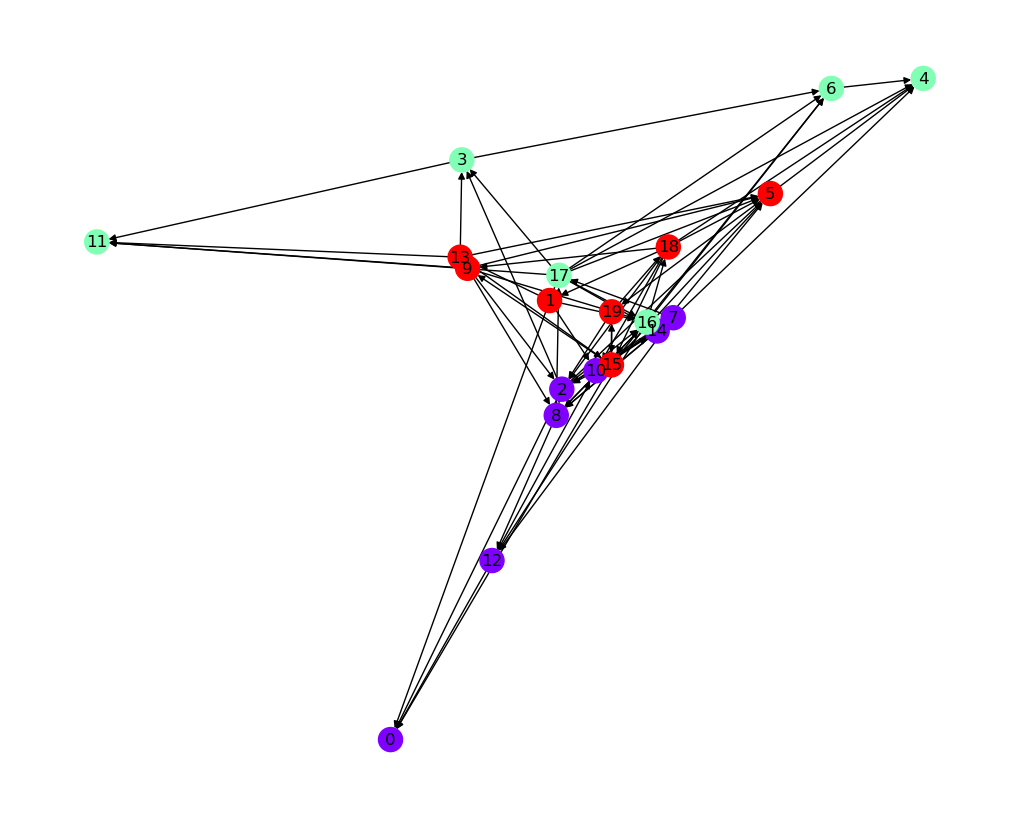

In [12]:
# Create a color map based on the partition
colors = [partition[node] for node in G.nodes()]

# Draw the graph with node colors based on community
plt.figure(figsize=(10, 8))
nx.draw(G, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.show()

In [5]:
G.add_edge(13, 19)
G.add_edge(14, 19)
#G.remove_edge(0, 18)

0

calculate edge counts df returns 3 dfs:
1. edge_sum_from_A_to_B_df: total sum to incomming edges for each node in A
2. binary_edge_count_df: same information but binary matrix where columns are edge counts 
3. edge_count_refined_df: columns are edge counts, but it counts how many edges come from each node in B. suppose there are 2 edges coming into a from b and c (b,c, in B) it will have 2 in column 2 (so that the total count for double edges is 2*2) - just another way to organize the edge count

In [13]:
#get subgraph for A_nodes and B_nodes
G_sub = G.subgraph(A_nodes + B_nodes)

# Calculate 3 edge count dfs
edge_sum_from_B_to_A_df, binary_edge_count_df, edge_count_refined_df = calculate_edge_counts(G_sub, A_nodes, B_nodes)


In [31]:
value_counts = edge_sum_from_B_to_A_df['Edge Count'].value_counts()

print("Value counts:", value_counts)

Edge Count
0    3
1    2
3    1
2    1
Name: count, dtype: int64


In [29]:
disparity, lc = calculate_disparity(edge_sum_from_B_to_A_df)

Disparity: 3
Distinct values: [1 3 0 2]
Value counts: Edge Count
0    3
1    2
3    1
2    1
Name: count, dtype: int64
Distinct value with largest count: 0


In [17]:
disparity_matrix_df = calculate_disparity_matrix(G, communities)
print(disparity_matrix_df)

Disparity: 3
Distinct values: [1 0 2]
Value counts: Edge Count
0    3
1    1
2    1
Name: count, dtype: int64
Distinct value with largest count: 0
Disparity: 3
Distinct values: [2 0 1]
Value counts: Edge Count
0    2
1    2
2    1
Name: count, dtype: int64
Distinct value with largest count: 0
Disparity: 2
Distinct values: [0 1]
Value counts: Edge Count
1    3
0    2
Name: count, dtype: int64
Distinct value with largest count: 1
Disparity: 3
Distinct values: [2 0 1]
Value counts: Edge Count
1    3
2    1
0    1
Name: count, dtype: int64
Distinct value with largest count: 1
Disparity: 3
Distinct values: [0 2 1]
Value counts: Edge Count
0    3
2    1
1    1
Name: count, dtype: int64
Distinct value with largest count: 0
Disparity: 3
Distinct values: [1 2 0]
Value counts: Edge Count
1    2
0    2
2    1
Name: count, dtype: int64
Distinct value with largest count: 1
Disparity: 2
Distinct values: [1 0]
Value counts: Edge Count
1    4
0    2
Name: count, dtype: int64
Distinct value with larges

# 1. Healthy Strongly connected component

In [3]:
# Import graph
file_path_graph = '/home/aya/alzh_genes_fibers/data/processed/clustering/brain_regions/Cerebellum/H/FHintS_graph.csv'
G_H_df = pd.read_csv(file_path_graph, sep='\t')

# import colors/clusters for Louvain Healthy (LH)
file_path_colors = '/home/aya/alzh_genes_fibers/data/processed/clustering/brain_regions/Cerebellum/H/F_louvain_colors_H.csv'
LH_df = pd.read_csv(file_path_colors, sep='\t', header=None)

In [16]:
# Create a directed graph from the DataFrame
G_H = nx.from_pandas_edgelist(G_H_df, source='transcription_factor', target='target', edge_attr='Weight', create_using=nx.DiGraph())

# Filter LH_df to only include nodes that are present in G_H
filtered_LH_df = LH_df[LH_df[0].isin(G_H.nodes())]

In [ ]:
# Create a dictionary from filtered_LH_df
cluster_dict = filtered_LH_df.groupby(1)[0].apply(list).to_dict()
# Rename keys in cluster_dict to start from 0
renamed_cluster_dict = {i: cluster_dict[key] for i, key in enumerate(cluster_dict.keys())}

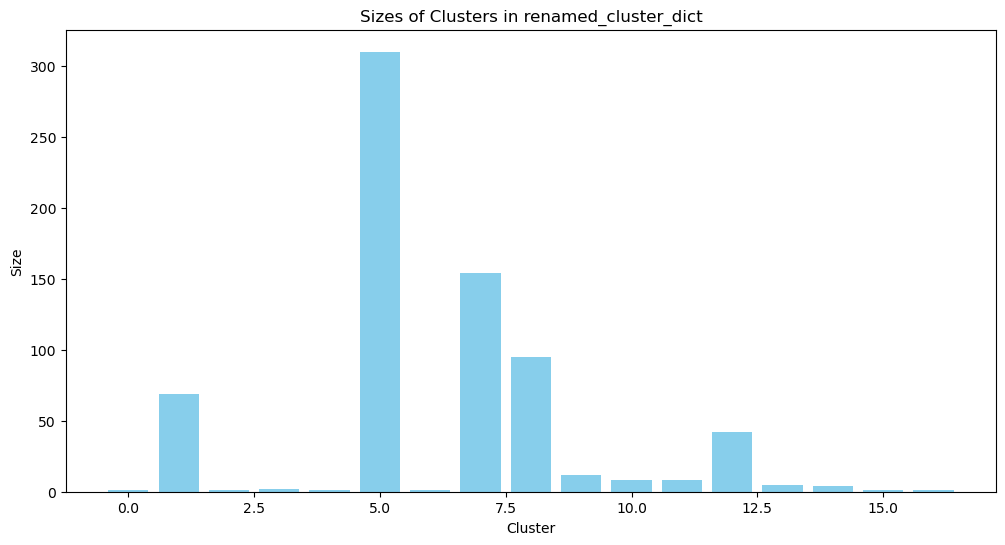

In [35]:
# Extract the sizes of the lists in renamed_cluster_dict
cluster_sizes = {key: len(value) for key, value in renamed_cluster_dict.items()}

# Create a DataFrame from the cluster sizes
cluster_sizes_df = pd.DataFrame(list(cluster_sizes.items()), columns=['Cluster', 'Size'])

# Plot the cluster sizes
plt.figure(figsize=(12, 6))
plt.bar(cluster_sizes_df['Cluster'], cluster_sizes_df['Size'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Sizes of Clusters in renamed_cluster_dict')
plt.show()

In [34]:
disparity_matrix_H_df = calculate_disparity_matrix(G_H, renamed_cluster_dict)

calculating disparity for in-degree of color 0 in respect to color 0
community A size: 1
community B size: 1
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    1
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 0 in respect to color 1
community A size: 1
community B size: 69
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    1
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 0 in respect to color 2
community A size: 1
community B size: 1
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    1
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 0 in respect to color 3
community A size: 1
community B size: 2
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    1
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 0 

Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    69
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 1 in respect to color 1
community A size: 69
community B size: 69
Disparity: 1
Distinct values: [0 1]
Value counts: Edge Count
0    66
1     3
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 1 in respect to color 2
community A size: 69
community B size: 1
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    69
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 1 in respect to color 3
community A size: 69
community B size: 2
Disparity: 0
Distinct values: [0]
Value counts: Edge Count
0    69
Name: count, dtype: int64
Distinct value with largest count: 0
calculating disparity for in-degree of color 1 in respect to color 4
community A size: 69
community B size: 1
Disparity: 0
Distinct values:

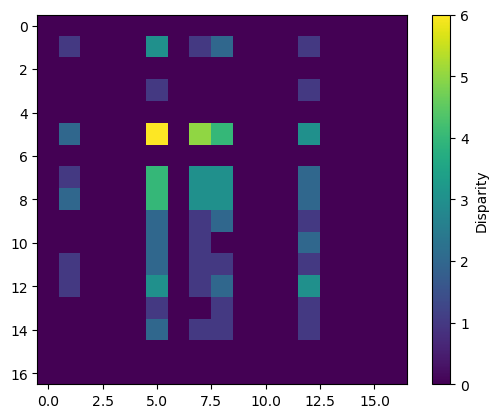

In [36]:
plt.imshow(disparity_matrix_H_df.to_numpy(), cmap='viridis')
plt.colorbar(label='Disparity')
plt.show()